in this notebook, we'll be using DoMPC to implement the 2 tanks analogy - the K will be allowed to vary accorindg to a random walk

## 2 Tanks

Imagine 2 tanks. The first has a input flow. There is a hole at the bottom which allow flow to move from tank 1 to tank 2. The hole allow for flowrate $Kh_1$ where $h_1$ is the current level of the tank. . The second tank accepts flow from tank 1 and flow leaves tank 2 at a flow rate $\eta h_2$. The equations are:

$$
\frac{dh_1}{dt} =  -K(t)h_1 + U_{i} \\
\frac{dh_2}{dt} =  K(t)h_1 + \eta h_2 
$$

$K(t) = f(T(t),\sigma)$ will be allowed to vary with temperature. Temperature, $T(t)$ will vary randomly in the day.

Additionally, the output of the system will only be the difference in the heights of the tanks
$$
y = h_1 - h_2 + n(t)
$$

where n(t) is some measurement noise

# Libraries

In [82]:
from scipy import integrate as inte
import numpy as np
import matplotlib.pyplot as plt
import do_mpc
from casadi import *
from matplotlib.animation import FuncAnimation

In [83]:
turn_meas_noise_on = False # Should we have measurement noise?
Tc = 2000 # Number of seconds to simulate for

In [84]:
def plot_tank_rajectory(simulator,sampling_freq=1):
    fig,ax = plt.subplots(2,2,figsize=(10, 9))
    
    states_sim = simulator.data['_x'][::sampling_freq]
    time =  simulator.data['_time'][::sampling_freq]
    K = simulator.data['_tvp'][::sampling_freq,0]
    force = simulator.data['_u'][::sampling_freq]
    output = simulator.data['_y'][::sampling_freq]
    
    ax[0,0].plot(time,states_sim[:,0],label = "h1")
    ax[0,0].plot(time,states_sim[:,1],label = "h2")
    ax[0,0].set_xlabel("Time")
    ax[0,0].set_ylabel("Tank Levels (m)")
    ax[0,0].legend()

    ax[0,1].plot(time,K)
    ax[0,1].set_xlabel("Time")
    ax[0,1].set_ylabel("K")
    
    ax[1,0].plot(time,output[:,0])
    ax[1,0].set_xlabel("Time")
    ax[1,0].set_ylabel("Tank height difference (m)")     
    
    ax[1,1].plot(time,force)
    ax[1,1].set_xlabel("Time")
    ax[1,1].set_ylabel("Input")     

# Model

In [85]:
# Defining the constants

eta = 0.1
model_type = 'continuous' # either 'discrete' or 'continuous'
model = do_mpc.model.Model(model_type)

x = model.set_variable(var_type='_x', var_name='x', shape=(2,1))
K = model.set_variable(var_type='_tvp', var_name='K', shape=(1, 1))
U_in = model.set_variable(var_type='_u', var_name='U_in', shape=(1,1))
x_next = vertcat(-K*x[0] + U_in, K*x[0] - eta*x[1])
model.set_rhs('x',x_next)



# State measurements
y = model.set_meas('y', x[0] - x[1], meas_noise=turn_meas_noise_on) # We have measurement noise for the states

# Input measurements
u_meas = model.set_meas('u_meas', U_in, meas_noise=False) # But we know exactly the u's


model.setup()

# Simulator

In [86]:

params_simulator = {
    # Note: cvode doesn't support DAE systems.
    'integration_tool': 'cvodes',
    'abstol': 1e-10,
    'reltol': 1e-10,
    't_step': 1
}

simulator = do_mpc.simulator.Simulator(model)
simulator.set_param(**params_simulator)

# Setting up the K. K is a quadraticve function of temperature 
temperature_data = np.zeros((Tc,))
temperature_data[0] = 20 # 20 degrees
for i in range(Tc-1):
    temperature_data[i+1] = temperature_data[i]+1*np.random.normal(0,1)

def friction(temp):
    #return 100*temp / temp
    return 0.1*temp**2 + 10 + 0.01*temp

max_friction = 2
min_friction = 0

friction_data = friction(temperature_data) + 8*np.random.normal(0,1,len(temperature_data))
friction_data_scaled = max_friction*(friction_data - min(friction_data)) / (max(friction_data) - min(friction_data)) 

# Set the time varying parameter
tvp_template = simulator.get_tvp_template()
def tvp_fun(t_now):
    tvp_template['K'] = friction_data_scaled[int(np.floor(t_now))]
    return tvp_template

simulator.set_tvp_fun(tvp_fun)
simulator.setup()



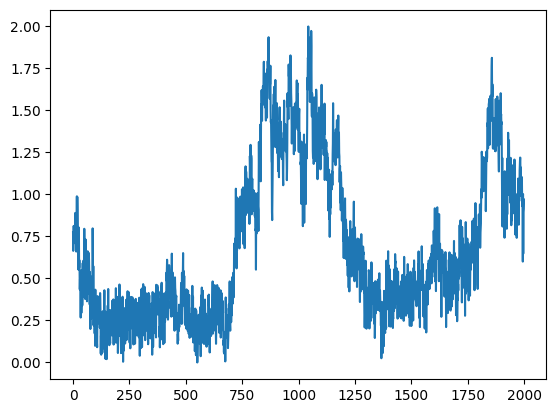

In [87]:
plt.plot(friction_data_scaled)

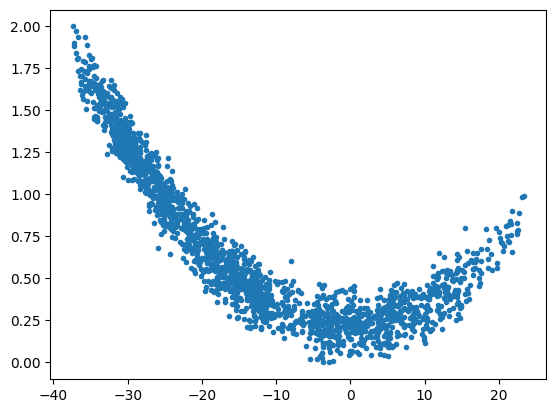

In [89]:
plt.plot(temperature_data,friction_data_scaled,'.')

# Simulation

In [113]:
def expert_controller(simulator,h_1_sp,gain = 1):
    current_h1 = simulator.data['_x'][-1,0]
    current_force = simulator.data['_u'][-1]
    u0_proposal = 1*(h_1_sp - current_h1) # Proportionate control
    if u0_proposal<0:
        u0 = 0
    elif abs(u0_proposal-current_force)>100:
        u0 = current_force
    else:
        u0 = u0_proposal
        
    return u0*np.ones((1,1))

In [114]:
u0 = 1*np.ones((1,1))
simulator.reset_history()
simulator.x0 = np.array([0,0])
for i in range(Tc):
    x0 = simulator.make_step(u0)
    u0 = expert_controller(simulator,3,gain = 1.5)
    
    


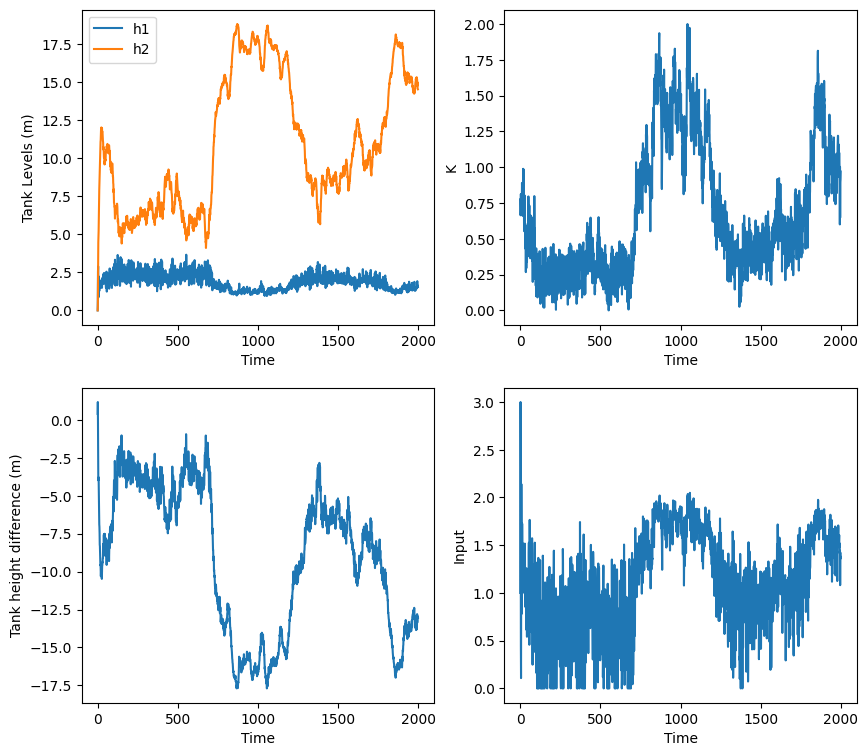

In [115]:
plot_tank_rajectory(simulator)

In [116]:
# Save the data
#print the data
import pandas as pd
data = np.hstack((simulator.data['_time'],
                  temperature_data[:,None],
                  simulator.data['_x'],
                  simulator.data['_u'],
                  simulator.data['_tvp']))

df = pd.DataFrame(data, columns = ['time','temperature','h1','h2','Uin','friction'])
df.to_csv('two_tanks_example.csv')


In [117]:
df

,time,temperature,h1,h2,Uin,friction
0,0.0,20.000000,0.000000,0.000000,1.000000,0.775936
1,1.0,20.549365,0.695582,0.293923,3.000000,0.664378
2,2.0,20.221726,2.549796,1.365999,2.304418,0.715936
3,3.0,20.964285,2.891809,3.105405,0.450204,0.812785
4,4.0,20.454506,1.591047,4.467871,0.108191,0.709974
...,...,...,...,...,...,...
1995,1995.0,-22.704743,1.918403,14.721136,1.442194,1.002401
1996,1996.0,-24.262452,1.614775,14.979234,1.081597,0.647669
1997,1997.0,-25.213631,1.641095,14.558134,1.385225,0.895220
1998,1998.0,-23.969682,1.585651,14.543335,1.358905,0.914182
